# Hate Speech Detection

I want to build an algorithim to  categorize tweets.  This will use the Hate Speach and Offensive Language dataset at [https://www.kaggle.com/datasets/mrmorj/hate\-speech\-and\-offensive\-language\-dataset?select=labeled\_data.csv](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?select=labeled_data.csv).  This dataset is 24782 tweets long with users voting on if the tweet is offensive 0, hate speach 1 or neither 2, with the winning label being selected as a class.  

## Goal

My goal is to identify groupings of tweets based on topic and then try to predict the classificaion of tweet as well as see if I get distinct topics. This is facinating as I see the fall of twitter and their ability to police tweets and wonder about how other sites automate this.

## Approach 

I am planning to use a combination of TF-IDF, matrix factorization, and clustering algorithims on tweets by 1 and 2 word clusters.  I will then create use featrue reduction, K-Means, and DBScan clustering to identify clusters.

### Disclaimer

This assignment necessary contains hate speach, and offensive langauge.  This does not represent the views of the author.

## Import


This data imports fairly easily.  I donloaded a copy of the file from kaggle and mirrored it to my GitHub so I could autodownload it for your use.  

## Data Description

The data concists of 24782 tweets which have been user labeled as either hate, offensive, or neither, along with a total cont of votes.  If you notice in the data, the Unnamed: 0 colun has 25296.  That was the origional tweet counter column, but there are some tweets missing.  In the initial data, the class is whichever category has the most votes.  The fields contain the text of the tweet, the count of votes on topic, the count of votes for each category, and the category that had the most votes.

## Basic Characteristics

The average character count of the uncleaned tweets is 85.  The average word count is 14.  
Number of words in each class: 1: Offensive Language 19190, 2: None 4163, 0: Hate Speech 1430.  This skew means that 1 category accounts for 77% of tweets and will heavily skew any classification attempts.

### My Big Mistake
My first and biggest mistake on this project was to not balance or account for the uneven data sizes.  This is likely one of the largest causes of the almost total failture of my training algorithim.  I spent way too much time on this, learning about GPU Processing (Nvidia Cuda ML), and Dask (Multi Host Paralellization), and I didn't have the time to redo everything.  The result of this failture is that my algorithim did not work any better than all 1's, which is 77%.   

In [38]:
#General Imports
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import statistics
from collections import Counter
#EDA Imports
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from sklearn.metrics import recall_score, precision_score, f1_score
import cuml, cupy, cudf
from cupyx.scipy import sparse as cusparse
from cupyx.scipy.sparse.linalg import svds as cusvds
#Model build Imports
from sklearn.cluster import DBSCAN
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics 

In [12]:
#Initial Import
raw_data = pd.read_csv('Data/labeled_data.csv', header = 0)
print(raw_data)
raw_data = raw_data.drop(columns = 'Unnamed: 0')

       Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0                   0        3      2   
1               1      3            0                   3        0      1   
2               2      3            0                   3        0      1   
3               3      3            0                   2        1      1   
4               4      6            0                   6        0      1   
...           ...    ...          ...                 ...      ...    ...   
24778       25291      3            0                   2        1      1   
24779       25292      3            0                   1        2      2   
24780       25294      3            0                   3        0      1   
24781       25295      6            0                   6        0      1   
24782       25296      3            0                   0        3      2   

                                                   tweet  
0      !!! RT @m

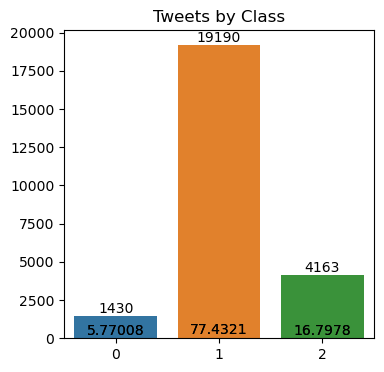

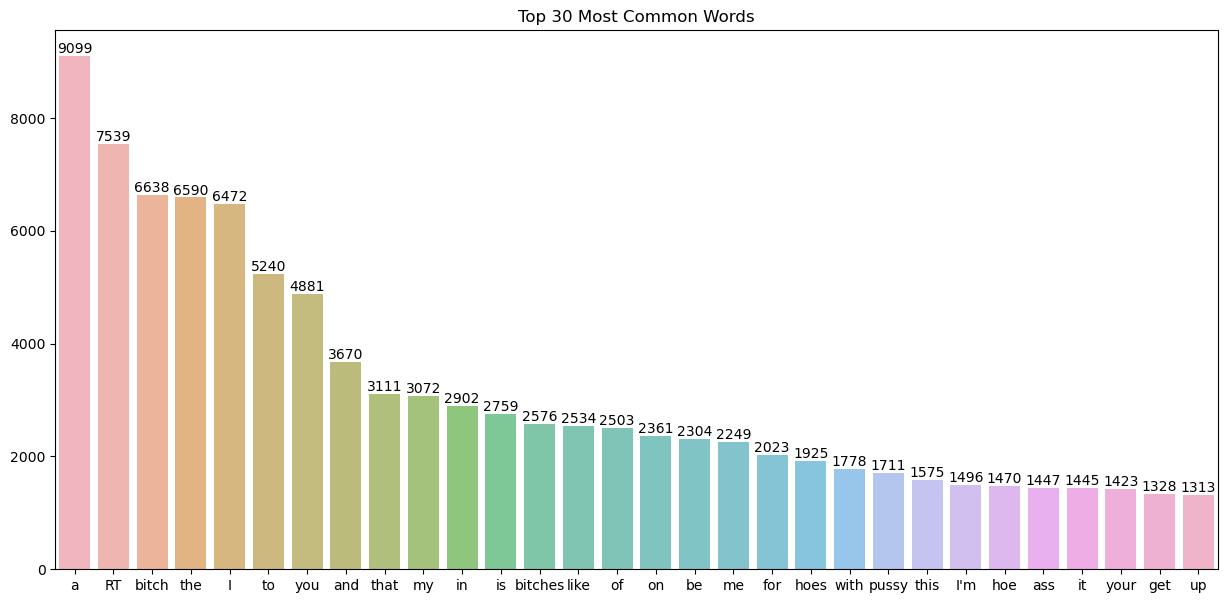

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
#Category Percent
keys = list(Counter(raw_data['class']).keys())
vals = [Counter(raw_data['class'])[k]/247.83 for k in keys]
az = sns.barplot(x=keys, y=vals, ax=ax)
az.set_title("%Tweets by Class")
for i in az.containers:
    az.bar_label(i,)

#Category Count
keys = list(Counter(raw_data['class']).keys())
vals = [Counter(raw_data['class'])[k] for k in keys]
az = sns.barplot(x=keys, y=vals, ax=ax)
az.set_title("Tweets by Class")
for i in az.containers:
    az.bar_label(i,)

#Most Common Words
bad_words = (Counter(" ".join(raw_data['tweet']).split()).most_common(30))
bad_words = list(zip(*bad_words))
fig, ax = plt.subplots(figsize=(15, 7))
ay = sns.barplot(x = list(bad_words[0]), y = list(bad_words[1]), ax=ax, alpha = .7)
ay.set_title("Top 30 Most Common Words")
for i in ay.containers:
    ay.bar_label(i,)

# Cleaning

## **Tweets with newline**

There appears to be a mismatch between the number of lines generated and the number of lines imported.  This is caused by newline characters, commas, quotation marks, and other supidity mixed in.  I chose to build my own parser to deal with all the issues and allow me to deal with the various problems with the data.\
**Update**\
There are skipped tweet numbers with no indicator in the dataset other than looking for them.

### **Some examples of problematic formating.**

22422,3,0,3,0,1,"This bitch fell straight through the chair... Im high, of course I laughed..\
\
\
\
Even if I wasn't I would've still laughed."

256,3,0,3,0,1,"""@TheNewSAT: #NewSATQuestions\
Yeah bitch, yeah bitch, call me _______:\
a.) Maybe\
b.) Steve-O\
c.) Later\
d.) Jesse Pinkman""\
@machinegunkelly"

## **Username Cleanup**

I chose to just drop all usernames.  This is due to usernames being random characters and it's out of scope for this project to try to do abusive username detection.

## URL's
URL's turned out to be especially trickly as there are some hidden URL's without the "://" symbols.  This caused me to have to go back in and perform a second cleaning round for URL's.

## **Unicode Characters, numbers, and non-letter characters**

I also chose to drop all unicode characters (Doing this save soo much time), numbers and most non-text characters.  The exception was the "*" character.  The * character is used to mask offensive words and when used, the resulting word length is fairly standard.

## **ReTweets**
I chose to remove the retweet "RT" from the dataset.  This may be able to be used as a category for other analasys but is not needed in this research.

# Lone S's and T's
After removing all non-letter characters, I had a large number of s and t hanging as whole words.  there are probably some other ones I missed, but these were in the top words.




In [14]:
def text_cleanup(text):
    #Remove usernames replace @xxx: with whitespace
    text = re.sub(r"@.*?:", " ", text)
    #remove unicode characters
    text = re.sub(r"&#[0-9]{1,6};", " ", text)
    #lowercase all text
    text = text.lower()
    #remove URL's
    text = re.sub(r'http[s]?:\/\/.*?"', " ", text)
    #Remove Residual URL's
    text = re.sub(r"\b(http[s]?|co[m]?)\b", "", text)
    #remove special characters and numberrs'
    #I chose to leave in *'s as they are a common manipulation to get around filters
    text = re.sub(r"[^a-z\*]", " ", text)
    #remove "RT"
    text = re.sub(r"\bRT\b", "", text)
    text = re.sub(r"rt\b", "", text)
    #remove lone T and S
    text = re.sub(r"\b(t|s|m)\b", "", text)
    #remove repeat whitespace and newlines
    text = re.sub(r"\s\s+", " ", text)
    text = re.sub(r"\n+", "", text)
    return text
    

raw_data["tweet"] = raw_data["tweet"].apply(text_cleanup)
print(raw_data['tweet'])


0         as a woman you shouldn complain about cleanin...
1         boy dats cold tyga dwn bad for cuffin dat hoe...
2         you ever fuck a bitch and she sta to cry you ...
3                        viva based she look like a tranny
4         the shit you hear about me might be true or i...
                               ...                        
24778    you a muthaf***in lie pearls corey emanuel rig...
24779    you ve gone and broke the wrong hea baby and d...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782     ruffled ntac eileen dahlia beautiful color co...
Name: tweet, Length: 24783, dtype: object


Mean Charater Count: 68.39184118145504
Mean Word Count: 14.294637453092847
Basic Data CharasiticsCounter({1: 19190, 2: 4163, 0: 1430})
30 Most common words.
68.39184118145504


Text(0.5, 1.0, 'Top 30 Most Common Words After Cleanup')

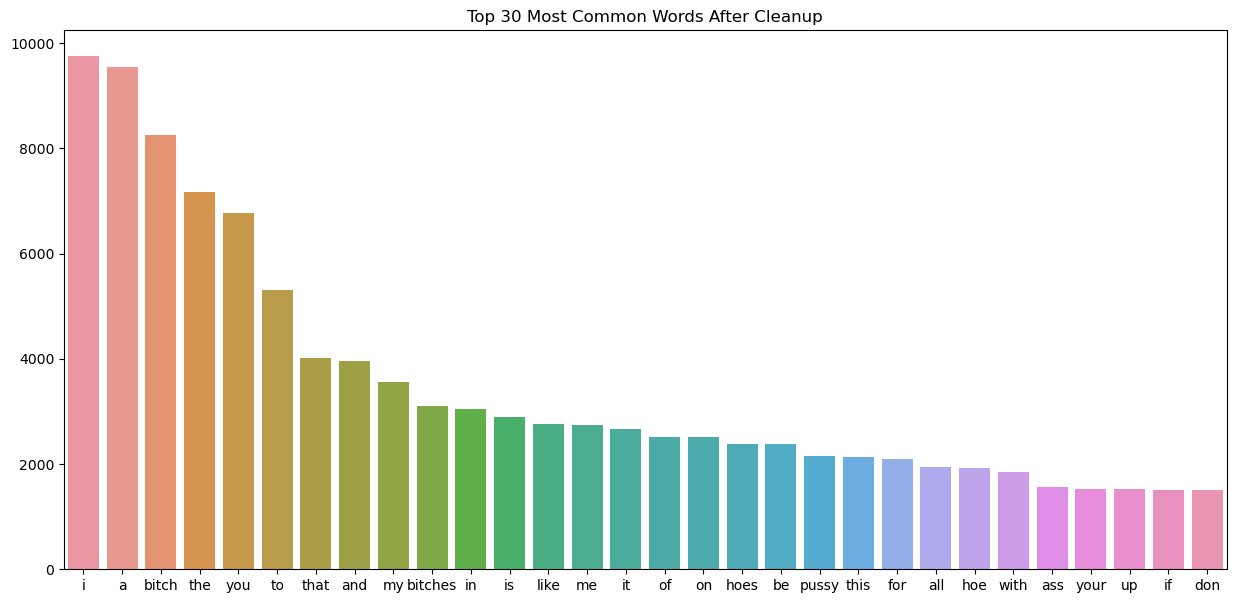

In [18]:
print("Mean Charater Count: " + str(statistics.mean(raw_data['tweet'].str.len())))
print("Mean Word Count: " + str(np.mean(raw_data['tweet'].apply(lambda x: len([words for words in x.split(" ") if isinstance(x, str)])))))
print("Basic Data Charasitics" + str(Counter(raw_data['class'])))
print("30 Most common words.")
bad_words = (Counter(" ".join(raw_data['tweet']).split()).most_common(30))
bad_words = list(zip(*bad_words))
print(statistics.mean(raw_data['tweet'].str.len()))

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x = list(bad_words[0]), y = list(bad_words[1]), ax=ax).set_title("Top 30 Most Common Words After Cleanup")

# EDA



## EDA Procedure

## Basic Data Charaistics After Cleanup

A tweet at the time of this data being collected can contain at maxiumum 280 Characters.  

## Formatting Data

I will start with dropping all the non-tweet columns.  This will be blind learning.

## Bagging

I chose to use TF\-IDF for my bagging procedure.  I performed EDA using Unigrams, Bigrams, Trigrams, and am removing common English stopwords.

Exploratory analays was done on unigrams, bigrams, and trigrams.  

### Attempt to get rid of highly common elements.

The initial runs of T-SNE returned really poor clusters.  In this I will rerun the TF\-IDF with a maximum document frequency of .2 and .15, and .10 and see if I get a better spread.  This change reduced the spacing between the 2 sets of elements.  I also used the ML alagorithim DBSCAN to color the graphs.

### Trigrams (And why I didn't run the whole project with them.
After I mostly completed the project, I decided to add trigrams to this step.  I found a slightly better perfomance in the 2d TF-IDF, but as rerunning all the calculations would be over 4 hours of computing time, I chose to stick with Bigrams and .15.

In [16]:
def TF_IDF(tweets, ngram_range, max_df):
    tfidf = TfidfVectorizer(input='content', encoding='utf-8', \
                            decode_error='strict', strip_accents='ascii', \
                            lowercase=True, preprocessor=None, tokenizer=None, \
                            analyzer='word', stop_words='english',  \
                            ngram_range=(ngram_range, ngram_range),max_df = max_df, max_features=None,\
                            vocabulary=None, binary=False, norm='l2', \
                            use_idf=True, smooth_idf=True, sublinear_tf=False)
    tfidf = tfidf.fit(tweets)
    tfidf_data = tfidf.transform(tweets)
    return tfidf_data

def TSNE_Process(tfidf_data, gram_size, k_val):
    tsne_results = TSNE(n_components=2, learning_rate='auto'\
                                 ,init='random', perplexity=30, n_iter = 600,\
                            n_jobs = -1).fit_transform(tfidf_data)
    tsne_results = pd.DataFrame(tsne_results, columns = ['x', 'y'])
    tsne_results['gram_size'] = gram_size
    tsne_results['k'] = k_val
    #print(tsne_results)
    return tsne_results

def build_model(tsne_results):
    #print(tsne_results.shape)
    dbscan = DBSCAN(eps=2.0, min_samples=100,\
                    metric='euclidean')

    tsne_results['predict'] = dbscan.fit_predict(tsne_results.drop(columns = ['gram_size', 'k']),\
                                                 tsne_results.drop(columns = ['gram_size', 'k']))
    tsne_results['predict'] = tsne_results['predict'].where(tsne_results['predict'] == 0, 1)
    #print(model_data['predict'].value_counts())
    #print(tsne_results)
    return tsne_results


In [ ]:
model_data = pd.DataFrame()
model_size = {'Unigram':1, 'Bigram':2, 'Trigram':3}
k_values = [1,0.15, .10]
                                                
for ms in model_size:
    for k_val in k_values:
        #print (ms)
        #print(model_size[ms])
        #print(k_val)
        
        TF_IDF_output = TF_IDF(raw_data['tweet'],model_size[ms] , k_val)
        TSNE_output = TSNE_Process(TF_IDF_output, ms, k_val)
        model_data = pd.concat([build_model(TSNE_output), model_data], axis = 0)
model_data.to_csv("Data/TSNE_Model.csv")


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


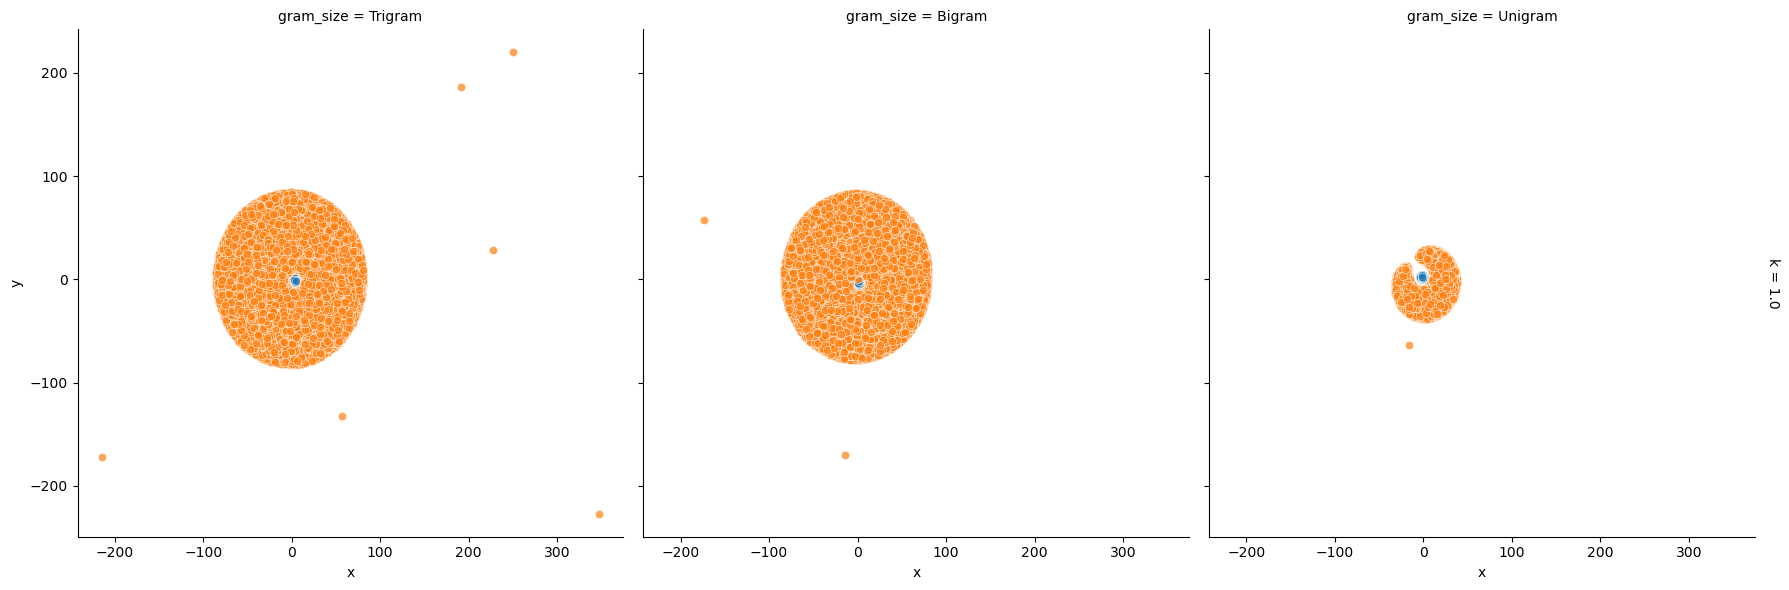

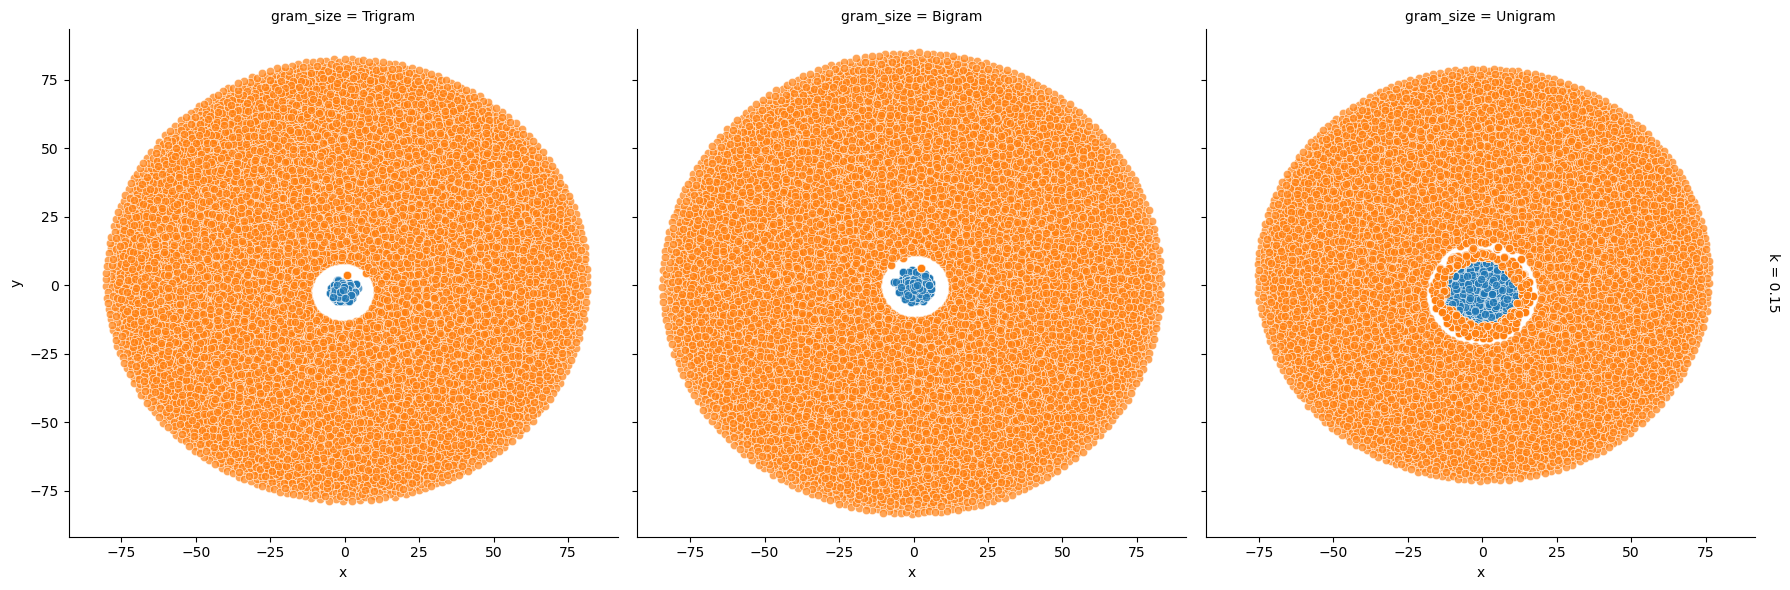

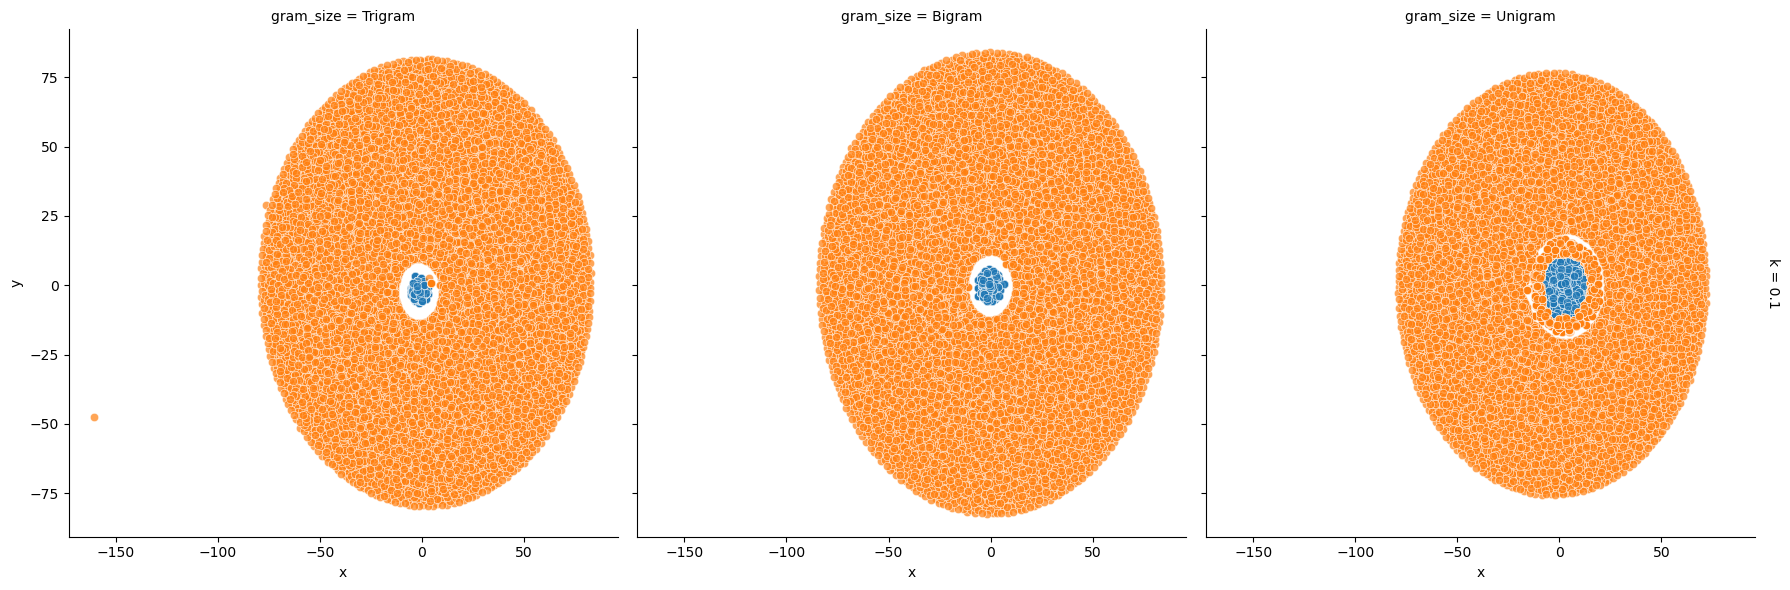

In [36]:
def color_graph(model_data, plot_title = ""):
    grid = sns.FacetGrid(model_data, col = 'gram_size',\
                        row = 'k', margin_titles=True,\
                        height=6, aspect=1, hue = 'predict')
    grid.map(sns.scatterplot, "x","y", legend="full" , alpha=0.7 )

    #print(model_data['predict'].value_counts())
    return 
#print(model_data['x'])
model_data = pd.read_csv("Data/TSNE_Model.csv")
for k_val in k_values:
    md = model_data[model_data['k'] == k_val]
    color_graph(md, "EDA TSNE Results")

## TSNE Results

TSNE using both unigrams, bigrams, and trigrams seems to have the similar results.  With 2 columns, there are limits to what the data comes up with.  In this case, the data is broken up into 1 cluster, and a bunch of residuals.   Just looking at some random results from each category, the groupings might be a division of hate speech vs offensive language.  For K=1, the groupings are pretty rough, while K=1. they are larger and more defined.

## Initial Algorithim
I chose to use the data that had undergone T-SNE to try and get a result.  I found that just paring down the data to 2 columns with bigrams I can create a model with a  70% precision.  This algorithim ignores the Also, although I didn't implement a fix action, the 34% for unigrams is likely just mis-assigned variables and could be higher.  I'll do a more comprehensive solution when I go further down this rabbit hole.


Unigram k = 1:  Raw Precision: 0.3468506637614494
Unigram k = 0.15:  Raw Precision: 0.5909696162692168
Unigram k = 0.1:  Raw Precision: 0.5935923818746721
Bigram k = 1:  Raw Precision: 0.6982609046523827
Bigram k = 0.15:  Raw Precision: 0.679457692773272
Bigram k = 0.1:  Raw Precision: 0.6794173425331881
Trigram k = 1:  Raw Precision: 0.7112536819594076
Trigram k = 0.15:  Raw Precision: 0.6944679820844935
Trigram k = 0.1:  Raw Precision: 0.6945890328047452


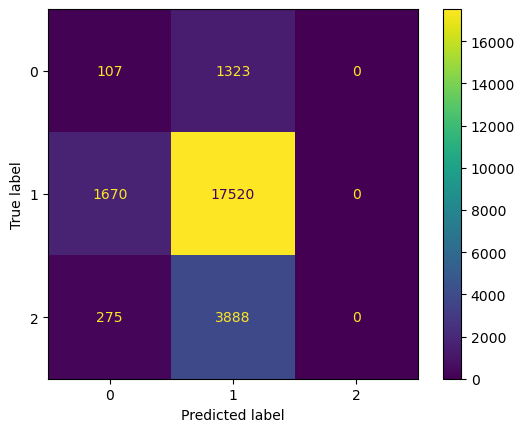

In [48]:
model_data = pd.read_csv("Data/TSNE_Model.csv")
def makeScores(d1, d2, text):
    print(text + ":  Raw Precision: " + str(precision_score(d1, d2, average = 'micro')))
k_values = [1,0.15, .10]
model_size = {'Unigram':1, 'Bigram':2, 'Trigram':3}
for ms in model_size:
    for k_val in k_values:
        makeScores(model_data[(model_data['gram_size'] == ms)\
                              & (model_data['k'] == k_val)]['predict'],\
                    raw_data['class'], str(ms) + " k = " + str(k_val))

confusion_matrix = metrics.confusion_matrix(raw_data['class'], model_data[(model_data['gram_size'] == 'Trigram')\
                              & (model_data['k'] == 1)]['predict']) 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show() 
model_data = None

## Model Building

I'm going to start with a DBSCAN model.  This is a popular model for text categorization and with the large doughnut hole in the middle of the data, I'm going to see if I can get the 2 blocks of data and test the results.

### K-Means
K-Means is an algorithim that tries to categorize the data by identifying centroids around a fixed number of groups of data with a fixed distance to the mean.

### Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN or Density-Based Spatial Clustering of Applications with Noise is a clustering algorithm that uses the density of data points to classify objects.  DBSCAN only has 2 values that can be tuned.  The EPS or distance to look to find groupings of points, and the K_Value or number of points to be considered a grouping.  Conveniently, DBSCAN can be used to predict new points as well.

### DBSCAN Optimization
I used a combination of ChatGPT recommendations (No Code though), and https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289 to make a process to find optomal parameters.  The process contains many steps.
1. Determine the optimal number of clusters.

### Principal Component Analasys (PCA)
PCA is a dimmensional reduction algorithim that is used to shrink very wide data to narrower data.  This will be used to shrink the data and find patterns and manage the size of the model.


### Use of GPU and Saving intermediate Data steps
Due to some of these algorithims taking a while to run, I swithched to using GPU compute.  Anywhere you see cuml, that is a GPU algorithim.  I also saved the results of most runs to disk to speed up processing time.

## SVD Generation
I wanted to see what would happen with a variety of SVD component sizes.  I therefore performed SVD to get a variety of data widths and ran most algorihtims on each of these.  I found out later that this was a major compute time and stored the values becuase of this.

In [ ]:
svd_data_components = [25, 50, 100, 200, 300, 400]
svd_data = {}
for i in svd_data_components:
    svd_data[i] = cusvds(cusparse.csr_matrix(TF_IDF(raw_data['tweet'], 2, .15)), k = i)[0]
    sparse.save_npz("SVD_Data/" + str(i) + ".npz", sparse.csr_matrix(svd_data[i].get()))
print(type(svd_data[25]))

In [27]:
svd_data_components = [25, 50, 100, 200, 300, 400]
svd_data = {}
for i in svd_data_components:
    svd_data[i] = sparse.load_npz("SVD_Data/" + str(i) + ".npz").todense()


## 1. K-Means Clustering Tests
Cluster number will be determined with K-Means and a silhouette score.  The silhouette score is an average of the density of the clusters.  Higher is better.

Initial Testing will be done using Bigrams with a TF_IDF Max document frequency of .15.  I would have tried with all of them, but I have limited compute and some of these compute runs took over 2 hours already.  

Here we find a peak silhouette score at 27 clusters, which means that the optimal number of clusters would be around 27.  The Silhouette Score of .007 clearly demonstrates that K-Means is unsutable for this data.


In [ ]:
#Data is the input data.  Range_n_clusters is a list of n_cluster sizes to test
#Ref https://cocalc.com/projects/af4af50d-ae0c-4e0d-952d-a06faaf430a4/files/Unsupervised-Learning-Final/Hate%20Speach%20Detection.ipynb#id=1bb809
#Precompute SVD Data.  I will use it alot


def k_means_silouette(svd_data, range_n_clusters):
    #print(data)
    s_scores = pd.DataFrame()
    for svd_component in svd_data.keys():
        svd_data_line = np.asarray(svd_data[svd_component])
        for n_clusters in range_n_clusters:
            cluster = cuml.KMeans(n_clusters = n_clusters)
            cluster_lables = cupy.asnumpy(cluster.fit_predict(svd_data_line))
            s_scores = pd.concat([s_scores,\
                                  pd.Series([n_clusters ,silhouette_score(svd_data_line, cluster_lables)\
                                                , svd_component], index = ["k_centroids", "silhouette_score"\
                                                                              , "svd_components"])], axis = 1)
    return s_scores.T

test_range_n_clusters = range(10, 200, 10)
s_scores = k_means_silouette(svd_data, test_range_n_clusters)
print(s_scores)
s_scores.to_csv("Data/s_scores.csv")                                                                              
                                                                             

## 2. Shilouette Scores
Shilouettes scores are a means to show how well clustered the data is.  A higher score shows better clusters.  As you can see, the optimal number of clusters is probably ~20 for 25 SVD components, with the Shilouette scores and increasing while the number of expected clusters also increased.  Realistically, after 300 SVD components, the data seems to become junk.  

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'SVD K_Values')

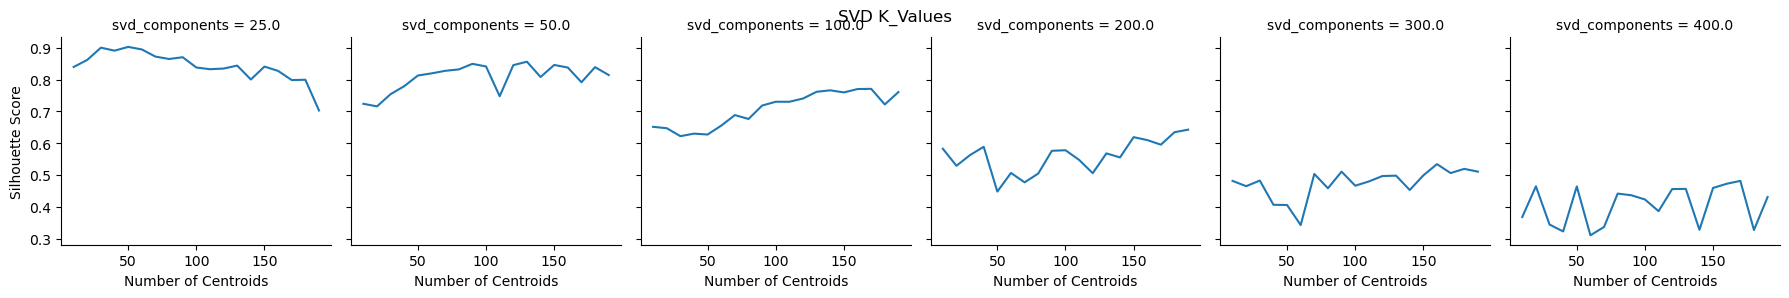

In [51]:
s_scores = pd.read_csv("Data/s_scores.csv")
plot = sns.FacetGrid(data = s_scores, col = "svd_components")
plot.map(sns.lineplot, "k_centroids", "silhouette_score")
plot.set(xlabel="Number of Centroids", ylabel="Silhouette Score")
plot.fig.suptitle("SVD K_Values") 

## 3. DBSCAN Analysis
DBSCAN has 2 hyper parameters, distance to the nearest neighbor to cluster, and how many samples constitute a cluster.  To tune these hyperparamenters, you first find the optimal distance between points.  Too large and you get too few clusters, too small, and you get too many clusters.  The second is to find the optimal number of points for clusters.

### Optimal DBSCAN parameters Discovery (EPS Scoring)
The first step of DBSCAN analyst is visualizing pairwise distances.  This means that we want to find the distance between a point and the next nearest point.  By finding this distance, we can find where the distance starts to increase sharply and use the "elbow" to find the optimal eps value.  To do this, I used K-Nearese Neighbor to sort the data and find the nearest neighbor and the distance to each neighbor.

### Possible Learning Point
If I was to do this again, I would have taken the derivitave to find the maximum rate of change of this graph and used that value.

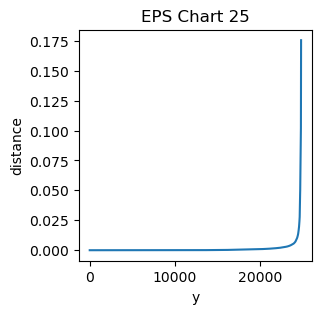

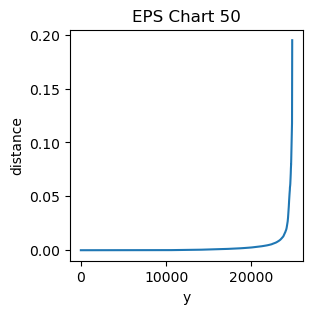

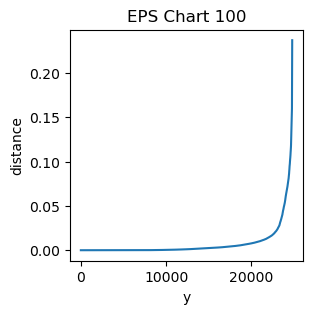

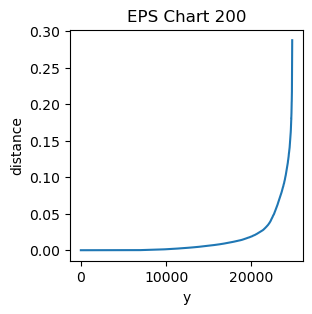

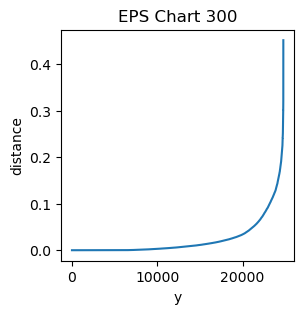

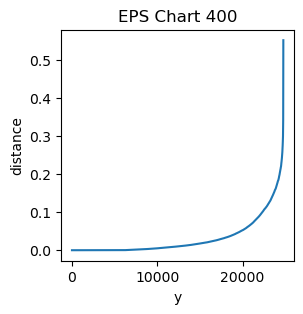

In [61]:
def calculate_optimal_eps(svd_data, k_neighbors, SVD_n_components = 0):
    distnaces = pd.DataFrame()
    for svd_component in svd_data.keys():
        #print(n_component)
        #svd_data = sparse.csr_matrix(cuml.TruncatedSVD(n_component)\
                                     #.fit_transform(data))
        svd_data_component = svd_data[svd_component]
        #print("tsvd complete")
        neighbors = cuml.NearestNeighbors(n_neighbors = k_neighbors)
        neighbors.fit(svd_data_component)
        #print("knn_fit_complete")
        distances, indices = neighbors.kneighbors(svd_data_component)
        #print("distance calc complete")
        kth_distance = kth_distances = distances[:, -1]
        sorted_distances = np.sort(kth_distance)
        #print("sortcomplete")
        sd = pd.DataFrame()
        #print(type(cupy.asnumpy(sorted_distances)))
        sd['distance'] = cupy.asnumpy(sorted_distances)
        #print(list(range(0,sd.shape[0])))
        sd['y'] = list(range(0,sd.shape[0]))
        sd['svd_component'] = svd_component
        distnaces = pd.concat([distnaces, sd])
        fig, ax = plt.subplots(figsize=(3, 3))
        
        sns.lineplot(y = sd['distance'], x  = sd['y'], ax = ax).set_title("EPS Chart " + str(svd_component))
    return distnaces
distnaces = calculate_optimal_eps(svd_data, 5, [25, 50, 100, 200, 400])


<Axes: xlabel='y', ylabel='distance'>

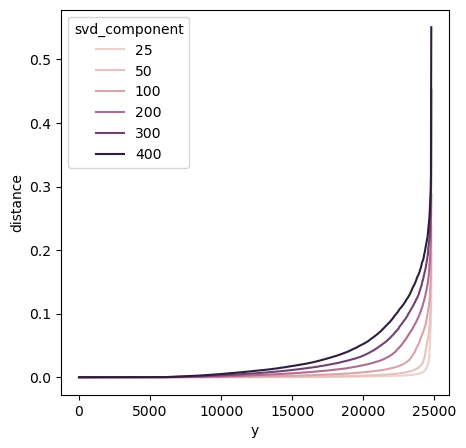

In [60]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(y = distnaces['distance'], x  = distnaces['y']\
             , hue = distnaces['svd_component'], ax = ax)

## EPS Score
The EPS Silhouette is there to dial in the correct value of distance between points.  I used the previous step as a guide.  I also wanted to explore what would happen with different values of the number of points to make a group.  As it turns out, it make a difference but also cut out the 2 steps after this one.  Also the groupings were much better where the elbow was more pronounced in the previous step.

### Processing Time Issues
This took over 2 hours to run all the different combinations. I also had problems with the final DataFrame and had to run this 4 times before I got data to keep.

In [ ]:
#EPS Test will generate SVD score chart.  Inputs will be data, a list of eps_values, and \
#a list of SVD_n_component values

def EPS_silhouette(svd_data, SVD_n_components):
    results = pd.DataFrame()
    for svd_component in SVD_n_components.keys():
        now = datetime.datetime.now()
        print("running for Component: " + str(svd_component))
        current_data = svd_data[svd_component]
        eps_min, eps_max = SVD_n_components[svd_component]
        eps_values = list(np.arange(eps_min, eps_max, (eps_max-eps_min)/15))
        for eps in eps_values:
            #print(eps)
            sample_values = [5,10,20,50,100,200]
            for sample_value in sample_values:
                dbs = cuml.DBSCAN(eps = eps, min_samples = sample_value).fit(current_data)
                #print("dbscan complete")
                core_sample_mask = np.zeros_like(dbs.labels_, dtype=bool)
                core_sample_mask[dbs.core_sample_indices_] = True
                item_res = pd.Series()
                item_res['num_labels'] = dbs.labels_.max()
                #print(Counter(list(dbs.labels_.tolist())).keys())
                if len(Counter(list(dbs.labels_.tolist())).keys()) == 1:
                    item_res['silhouette'] = 0
                else:
                    item_res['silhouette'] = silhouette_score(cupy.asnumpy(current_data), cupy.asnumpy(dbs.labels_))

                #print("silhouette score complete")
                item_res['eps'] = eps
                item_res['comp'] = svd_component
                item_res['sample_value'] = sample_value
                results = pd.concat([results, item_res], axis = 1)
        print(datetime.datetime.now()-now)

    return results.T
eps_silhouette_data = EPS_silhouette(svd_data, {25: (0.0,.020), 50:(.005, .05), 100:(.005, .05), 200:(.02, .07), 400:(.05, .20)})
eps_silhouette_data.to_csv('Data/eps_silhouette_data.csv')

Text(0, 0.5, 'Silhouette Score')

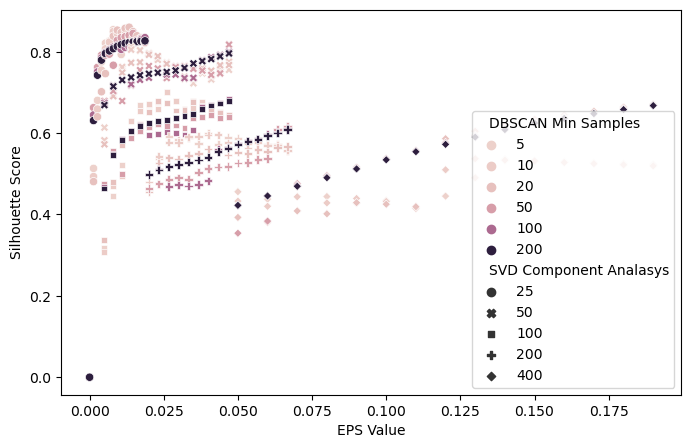

In [21]:
eps_silhouette_data = pd.read_csv('Data/eps_silhouette_data.csv')
eps_silhouette_data['DBSCAN Min Samples'] = eps_silhouette_data['sample_value'].astype(int)
eps_silhouette_data['SVD Component Analasys'] = eps_silhouette_data['comp'].astype(int)
eps_silhouette_data['Number of Clusters'] = eps_silhouette_data['num_labels'].astype(int)
eps_silhouette_data  = eps_silhouette_data.drop(columns = ['sample_value', 'comp', 'Unnamed: 0', 'num_labels'])
fig, ax = plt.subplots(figsize=(8, 5))
#print(eps_silhouette_data)
plot1 = sns.scatterplot(data = eps_silhouette_data, x ='eps', \
                        y ='silhouette', hue ='DBSCAN Min Samples', \
                        style = 'SVD Component Analasys', ax = ax)
plot1.set_xlabel("EPS Value")
plot1.set_ylabel("Silhouette Score")

## Finding the best hyperparameters
I did a quick search for max hyperparametrs to find the final values.  Unfortunately, I have a whole lot of top selecions with no clusters.  I'll try again filtering for where clusters were found.

In [22]:
for comp in [25, 50, 100, 200, 400]:
    df = eps_silhouette_data[eps_silhouette_data['SVD Component Analasys'] == comp]
    print(df.loc[df['silhouette'].idxmax()])

silhouette                 0.860339
eps                        0.013333
DBSCAN Min Samples        20.000000
SVD Component Analasys    25.000000
Number of Clusters        17.000000
Name: 62, dtype: float64
silhouette                 0.817554
eps                        0.047000
DBSCAN Min Samples        50.000000
SVD Component Analasys    50.000000
Number of Clusters         0.000000
Name: 177, dtype: float64
silhouette                  0.700222
eps                         0.026000
DBSCAN Min Samples          5.000000
SVD Component Analasys    100.000000
Number of Clusters        125.000000
Name: 222, dtype: float64
silhouette                  0.616560
eps                         0.066667
DBSCAN Min Samples         50.000000
SVD Component Analasys    200.000000
Number of Clusters          0.000000
Name: 357, dtype: float64
silhouette                  0.671024
eps                         0.190000
DBSCAN Min Samples         20.000000
SVD Component Analasys    400.000000
Number of Clusters 

## Better
Now I have hyperparameters where clusters were found. The best clusters were found where the SVD Width was narrower.

In [9]:
max_silhouette = pd.DataFrame()
for comp in [25, 50, 100, 200, 400]:
    df = eps_silhouette_data[(eps_silhouette_data['SVD Component Analasys'] == comp) & (eps_silhouette_data['Number of Clusters'] > 0)]
    max_silhouette = pd.concat([max_silhouette, df.loc[df['silhouette'].idxmax()]], axis = 1)
    print(df.loc[df['silhouette'].idxmax()])
max_silhouette = max_silhouette.T
print(max_silhouette)

silhouette                 0.860339
eps                        0.013333
DBSCAN Min Samples        20.000000
SVD Component Analasys    25.000000
Number of Clusters        17.000000
Name: 62, dtype: float64
silhouette                 0.811964
eps                        0.014000
DBSCAN Min Samples         5.000000
SVD Component Analasys    50.000000
Number of Clusters        84.000000
Name: 108, dtype: float64
silhouette                  0.700222
eps                         0.026000
DBSCAN Min Samples          5.000000
SVD Component Analasys    100.000000
Number of Clusters        125.000000
Name: 222, dtype: float64
silhouette                  0.599186
eps                         0.040000
DBSCAN Min Samples          5.000000
SVD Component Analasys    200.000000
Number of Clusters        199.000000
Name: 306, dtype: float64
silhouette                  0.537129
eps                         0.130000
DBSCAN Min Samples         10.000000
SVD Component Analasys    400.000000
Number of Clusters 

## Final Model Build and score
Here, I ran the final DBSCAN model with my optimal hyper-parameters and plotted Confusion Matricies.  The results are underwhelming.

Test for SVD of 25
0.7748860105717629


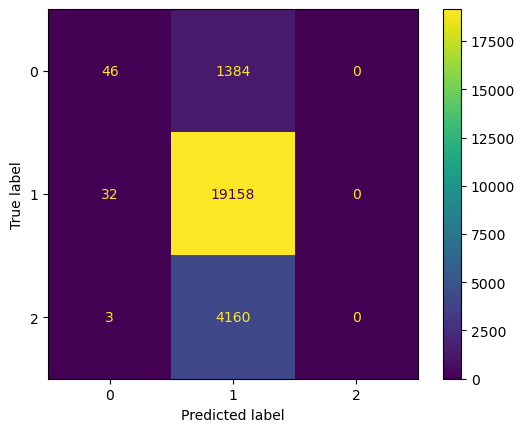

Test for SVD of 50
0.7769842230561271


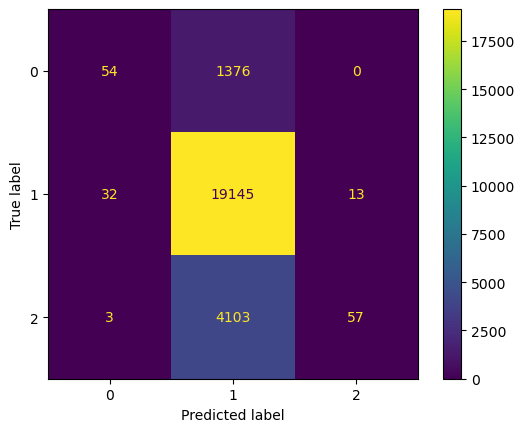

Test for SVD of 100
0.7776701771375539


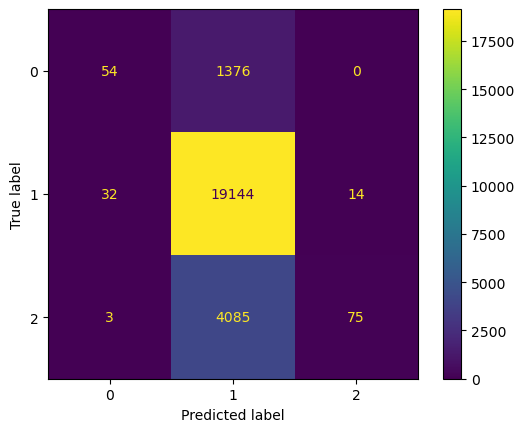

Test for SVD of 200
0.7803736432231771


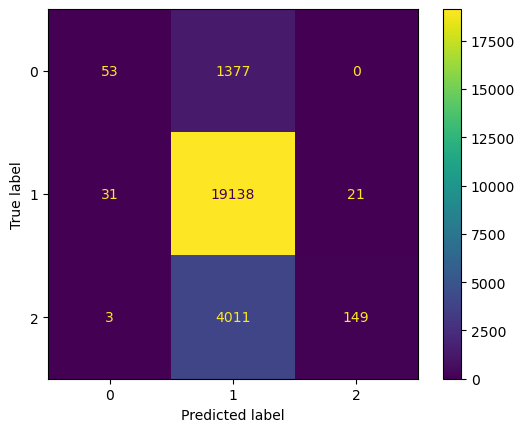

Test for SVD of 400
0.7768228220957915


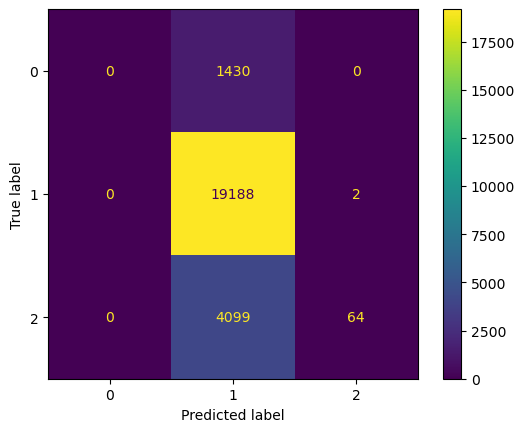

In [69]:
final_model_score = {}
for comp in [25, 50, 100, 200, 400]:
    df = max_silhouette[max_silhouette['SVD Component Analasys'] == comp].squeeze('rows')
    svd_data_component = svd_data[int(df['SVD Component Analasys'])]
    dbs = cuml.DBSCAN(eps = df.eps, min_samples = df['DBSCAN Min Samples']).fit(svd_data_component)
    lables = pd.DataFrame(dbs.labels_)
    max_label = dbs.labels_.max()
    for row in range(-1, dbs.labels_.max()+1):
        test_row = raw_data.iloc[lables[lables[0] == row].index.tolist()]['class']
        max_score = 0.0
        max_val = -1 
        for test_val in range(0,3):
            score = precision_score([test_val]*len(test_row), test_row, average = 'micro')
            if score > max_score:
                max_score = score
                max_val = test_val
        #print(max_score, max_val)
        raw_data.loc[lables[lables[0] == row].index.tolist(), 'train_predict'] = max_val
    print("Test for SVD of " + str(comp))
    ps = precision_score(raw_data['class'], raw_data['train_predict'], average = 'micro')
    print(ps)
    #Test for all 1's
    confusion_matrix = metrics.confusion_matrix(raw_data['class'], raw_data['train_predict']) 
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.show() 
    final_model_score[comp] = ps

    


# Conclusion
## Data
The Results are underwhelming.  At best, I get a raw accuracy of 78%.  If I predict all 1's I will get 77%.  My first and largest mistake was using unbalanced data, driving the 1's to train poorly.  This algorighim should have done well but there are other text classification algorithims I could have used.
## What went well
This was an awesome learning expirence in clustering data.  I learned to use GPU processing, and got a great feel for DBSCAN.  I plan to use DBSCAN to color 2d and 3d Graphs in the future if nothing else.  I aslo started to learn about but didn't end up using DASK paralell processing.  The time it would have taken me to configure and run dask and deploy a AWS DASK cluter would have been much longer than my 2 hour crunch time
## What went badly
I got really poor results.  The bronze standard on Kaggle is 85%, but they took a wholly different approach.  Also, I did this using a lot of brute force resulting in this taking very long to process computationally.